<div style="text-align: center"><h1 style="text-decoration: underline;">DSML Project</h1></div>



This is the official Notebook of the DSML Project from Marc Rennefort, Kilian Lipinsky, Timo Hagelberg, Jan Behrendt-Emden and Paul Severin. In order to create this Project we used the following dataset: https://data.cityofchicago.org/Transportation/Transportation-Network-Providers-Trips-2023-2024-/n26f-ihde/about_data

In [31]:
#Note all your imports here
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from holoviews.plotting.plotly import ScatterPlot
from mpmath import sumap
from numpy.ma.core import inner
from pandas.core.common import random_state
#from skimage.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
%matplotlib inline
from sklearn.tree import DecisionTreeClassifier
import seaborn as sns
from sklearn.linear_model import LinearRegression
from datetime import datetime
from sklearn.model_selection import train_test_split
from meteostat import Hourly, Point
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score, precision_score, f1_score


<h4 style="text-decoration: underline;">1. Buisness Understanding</h4>
The given dataset contains all trips in 2023-2024 to the city of chicago reportet by rideshare companies such as Uber. With this data we want to train a model that helps use to predict the tip in ride hailing trips as accurate as possible. This could be interesting for Uber drivers to plan their rides on routes and days which give the most tip. In addition it could also help Uber as a company to make appropriate sales forecasts. For our prediction we want to include the following features: travel time, distance, fare amount, weather conditions, and whether the customer shared the ride. At this point it should be said that the tip values are not exact because they are rounded to the nearest $1.00 and only digital tips are included in the dataset, as tips paid in cash don't get tracked.


<h4 style="text-decoration: underline;">2. Data Understanding and Data Prepertion</h4>

<h4 style="text-decoration: underline;">2.1 Some Basic Data Preperation</h4>
In the first step we want to do some basic data preperartion and data understanding which means that we load our data set with the columns we need, we drop all rows with null values and changing our timestamps to datetime format.

In [ ]:
#Loading our dataset with the columns we need
data_cleaned = pd.read_csv('Data/Chicago_RideHailing_Data.csv', usecols= ['Trip End Timestamp', 'Trip Seconds', 'Trip Miles', 'Tip', 'Trip Total','Dropoff Centroid Latitude', 'Dropoff Centroid Longitude', 'Shared Trip Authorized', 'Shared Trip Match'])

#We can't use the Total including Tip, so we will calculate the cost (Fare + other Charges) as Total - Tip
data_cleaned['Cost'] = data_cleaned['Trip Total'] - data_cleaned['Tip']
data_cleaned = data_cleaned.drop(columns=['Trip Total'])

In [ ]:
#Get some basic understanding of our data
print('Null Values: ', data_cleaned.isnull().sum())
data_cleaned.info()
data_cleaned.head()

In [ ]:
#Drop all rows with null values
data_cleaned = data_cleaned.dropna(axis = 0)

In [ ]:
#Changing our timestamp to datetime format
data_cleaned['Trip End Timestamp'] = pd.to_datetime(data_cleaned['Trip End Timestamp'],  format='%m/%d/%Y %I:%M:%S %p', errors='coerce')

In [ ]:
#Check if everything worked correctly
print('Null-Werte: ', data_cleaned.isnull().sum())
data_cleaned.info()

<h4 style="text-decoration: underline;">2.2 Including weather data</h4>
In order to add the weather data we need to group our data because otherwise we will get runtime issues if we do API calls for barely 25 Million rows. This should be fine for our prediction purposes because there won't be huge differences in temperature or rain if we round by the second decimal place

In [ ]:
#Round the Latitude and Longitude by the second decimal place and insert it in a new column
data_cleaned["Latitude rounded"] =  data_cleaned["Dropoff Centroid Latitude"].round(2)
data_cleaned["Longitude rounded"] = data_cleaned["Dropoff Centroid Longitude"].round(2)

#Group the data by Latitude and Longitude
data_grouped = data_cleaned.groupby(["Latitude rounded", "Longitude rounded"])["Trip End Timestamp"].agg(["min", "max"]).reset_index()
data_grouped.head()

In [ ]:
weather_list = []
for i in range(len(data_grouped)):
    #Initalise variables
    latitude = data_grouped["Latitude rounded"].iloc[i]
    longitude = data_grouped["Longitude rounded"].iloc[i]
    location = Point(latitude, longitude)
    timestamp_min = data_grouped["min"].iloc[i]
    timestamp_max = data_grouped["max"].iloc[i]
    
    #Round min and max column to the next hour in order to extract the weather data correctly
    timestamp_min_rounded = timestamp_min.replace(minute = 0, second = 0) 
    timestamp_max_rounded = timestamp_max.replace(minute = 0, second = 0)
    
    #Extract the weather data per location
    weather = Hourly(location, timestamp_min_rounded, timestamp_max_rounded).fetch()

    #Merge the extracted weather data with the fitting timestamps and locations
    for j in range(len(weather)):
       weather_list.append({"Timestamp": weather.index[j], "Latitude rounded": latitude, "Longitude rounded": longitude, "Temperature": weather["temp"].iloc[j], "Rain in mm": weather["prcp"].iloc[j]})

#Covert the list to a DataFrame
weather_data = pd.DataFrame(weather_list)
weather_data.head()

In [ ]:
print(weather_data.isnull().sum())
weather_data = weather_data.dropna(axis=0)

In [ ]:
#Now we prepare the merge of the weather data and the other data. For this we need to round our timestamps by the next hour because our weather data is given hourly
data_cleaned["Trip End Timestamp Rounded"] = data_cleaned["Trip End Timestamp"].dt.floor("h")


In [ ]:
#In the next step we can start with the merge
data_merged = pd.merge(data_cleaned, weather_data, left_on=["Trip End Timestamp Rounded", "Latitude rounded", "Longitude rounded"], right_on =["Timestamp", "Latitude rounded", "Longitude rounded"], how = "inner")

In [ ]:
# Now we check if we introduced any null values with our weather data or during the merge
print('Null-Werte: ', data_merged.isnull().sum())


In [ ]:
#After that we can drop all the columns we just needed to merge our data
data_merged = data_merged.drop(columns = ["Dropoff Centroid Latitude", "Dropoff Centroid Longitude", "Latitude rounded", "Longitude rounded", "Timestamp" ,"Trip End Timestamp Rounded"])
data_merged.head()

<h4 style="text-decoration: underline;">2.3 Creation of dummy variables</h4>
To perform or regression later on we need to transfer the 'Shared Trip Authorized', 'Shared Trip Match' and 'Trip End Timestamp' column to numeric datatype. For this we make use of dummy variable where 1 stands for true and 0 stands for false for the Shared Trip variables and different variables for the time of day in case of the Trip End variable. In addition we need to creat dummy variables for the rain because we are not interested in the amount of rain on a certain day rather we want to plot wheter it rained or not. 

In [ ]:
#Create dummy variable for 'Shared Trip Authorized' and 'Shared Trip Match' (1 = True and 0 = False)
data_merged["Shared Trip Authorized"] = data_merged["Shared Trip Authorized"].astype(int)
data_merged["Shared Trip Match"] = data_merged["Shared Trip Match"].astype(int)
print("📋First 5 Rows:")
data_merged.head()


In [ ]:
#Create dummy variables for the Trip End Timestamp: 22:00-6:00 for night, 6:00-18:00 for day and 18:00-22:00 for evening
data_merged["Trip End Hour"] = data_merged["Trip End Timestamp"].dt.hour
data_merged["Night"] = np.where((data_merged["Trip End Hour"] >= 22) | (data_merged["Trip End Hour"] < 6), 1, 0)
data_merged["Day"] = np.where((data_merged["Trip End Hour"] >= 6) & (data_merged["Trip End Hour"] < 18), 1, 0)
data_merged["Evening"] = np.where((data_merged["Trip End Hour"] >= 18) & (data_merged["Trip End Hour"] < 22), 1, 0)
#Drop the Trip End Hour & Trip End Timestamp column as we don't need them anymore
data_merged = data_merged.drop(columns=["Trip End Hour", "Trip End Timestamp"])

data_merged.head()

In [ ]:
#We see that the column 'Rain in mm' is from datatype object but we need a numeric datatype, so we need to transform this column to the right datatype
data_merged['Rain in mm'] = pd.to_numeric(data_merged['Rain in mm'], errors='coerce')

In [ ]:
#Switching the columns so that all dummy variables will be after all numeric variables
data_merged = data_merged[['Tip', 'Trip Seconds', 'Trip Miles', 'Cost', 'Temperature', 'Rain in mm', 'Shared Trip Authorized', 'Shared Trip Match', 'Day', 'Evening', 'Night']]

<h4 style="text-decoration: underline;">2.4 Dealing with outliers</h4>
Outliers are often caused by errors in data collection. Therefore it is important to identify and remove them as they can distort the performance of predictive models by representing values that do not reflect typical or real-world scenarios. In the following we attempted to remove outliers using the standard deviation method. However, it must be acknowledged that we cannot say with complete certainty whether each detected outlier represents a data collection error or simply reflects rare but valid cases—since we did not collect the data ourselves. Nevertheless this approach helps us prepare the dataset as effectively as possible for building robust predictive models
 

In [ ]:

#We don't need to deal with outliers on the columns with dummy variables because there can't be outliers if we just have the values 0 or 1
data_merged_without_tip = data_merged.drop(columns = ["Shared Trip Authorized", "Shared Trip Match", "Night", "Day", "Evening"])
for columns in data_merged_without_tip.columns:
    #Calculate mean and standard deviation of the current column
    mean = data_merged_without_tip[columns].mean()
    std = data_merged_without_tip[columns].std()
    
    #Calculate upper and lower limit
    upperlimit = mean + 3 * std
    lowerlimit = mean - 3 * std

    #Replace all outliers with null values so we can remove them later
    data_merged.loc[(data_merged[columns] > upperlimit) | (data_merged[columns] < lowerlimit), columns] = np.nan

#Remove all null values (delete all outliers)    
data_without_outliers = data_merged.dropna(axis = 0)
print(f"❌ Deleted {len(data_merged) - len(data_without_outliers)} outliers")


<h4 style="text-decoration: underline;">2.5 Saving the data</h4>
We will save the preperated data here, so that we can continue working with it, without having to rerun all the code above every time we start.


In [ ]:
data_without_outliers.to_csv('Data/Chicago_RideHailing_Data_Cleaned.csv', index=False)

<h4 style="text-decoration: underline;">3. Data Modeling</h4>
If you have already saved the data you can use this shortcut to save some runtime.

In [2]:
data_without_outliers = pd.read_csv('Data/Chicago_RideHailing_Data_Cleaned.csv')
#Check if everything worked correctly
data_without_outliers.head()

,Tip,Trip Seconds,Trip Miles,Cost,Temperature,Rain in mm,Shared Trip Authorized,Shared Trip Match,Day,Evening,Night
0,0.0,3109.0,23.5,40.70,16.7,0.3,0,0,0,1,0
1,0.0,1640.0,14.7,38.74,18.9,0.0,0,0,1,0,0
2,0.0,772.0,1.9,22.39,31.1,0.0,0,0,1,0,0
3,0.0,452.0,1.1,14.07,17.8,0.0,0,0,1,0,0
4,0.0,819.0,3.9,12.89,16.1,0.0,0,0,1,0,0


<h4 style="text-decoration: underline;">3.1 Train Test Validation Split</h4>
First of all we need to split our data in train, test and validation data.

In [3]:
#Define x and y vectors
x = data_without_outliers.drop(columns = ["Tip"])
y = data_without_outliers["Tip"]

#Perform train test validation split
x_train_data, x_test_data, y_train_data, y_test_data = train_test_split(x, y, test_size = 0.3, random_state = 42)
x_val_data, x_test_data, y_val_data, y_test_data = train_test_split(x_test_data, y_test_data, test_size = 0.5, random_state = 42)
print("Datasplit:")
print(f"🏋️ Training: {len(x_train_data)} Samples ({len(x_train_data)/len(data_without_outliers)*100:.1f}%)")
print(f"🔬 Testing: {len(x_test_data)} Samples ({len(x_test_data)/len(data_without_outliers)*100:.1f}%)")
print(f"✅ Validation: {len(x_val_data)} Samples ({len(x_val_data)/len(data_without_outliers)*100:.1f}%)")

Datasplit:
🏋️ Training: 15796417 Samples (70.0%)
🔬 Testing: 3384947 Samples (15.0%)
✅ Validation: 3384947 Samples (15.0%)


In [4]:
#Because we want to train two diffrent models in the classification approach we need to create two different training datasets (only relevant for classification)

x_train1_data, x_train2_data, y_train1_data, y_train2_data = train_test_split(x_train_data, y_train_data, test_size = 0.5, random_state = 42)
print("Datasplit:")
print(f"Train Model 1: {len(x_train1_data)} Samples ({len(x_train1_data)/len(data_without_outliers)*100:.1f}%)")
print(f"Train Model 2: {len(x_train2_data)} Samples ({len(x_train2_data)/len(data_without_outliers)*100:.1f}%)")

Datasplit:
Train Model 1: 7898208 Samples (35.0%)
Train Model 2: 7898209 Samples (35.0%)


<h4 style="text-decoration: underline;">3.2 Descriptive analyses Split</h4>
Now we will look at key statistics about our data. We only use the training data for this, in order to rule out accidental data leakage.

In [5]:
#Create a table with a column for each feature and key statistics as rows
def create_statistics_table(df):
    stats = pd.DataFrame(index=['Mean', 'Median', 'Standard Deviation', 'Min', 'Max', 'Range'])
    for column in df.columns:
        stats[column] = [
            df[column].mean(),
            df[column].median(),
            df[column].std(),
            df[column].min(),
            df[column].max(),
            df[column].max() - df[column].min()
        ]
    return stats

#Create statistics table for the training data
features_stats_table = create_statistics_table(x_train_data.drop(columns=['Shared Trip Authorized', 'Shared Trip Match', 'Night', 'Day', 'Evening']))
target_stats_table = create_statistics_table(y_train_data.to_frame(name='Tip'))
stats_table = pd.concat([target_stats_table.rename(columns={'Tip': 'Tip (Target)'}), features_stats_table], axis=1)
stats_table.head(len(stats_table))

,Tip (Target),Trip Seconds,Trip Miles,Cost,Temperature,Rain in mm
Mean,0.896794,954.234796,5.204585,17.365140,9.465982,0.056994
Median,0.000000,807.000000,3.400000,14.730000,8.300000,0.000000
Standard Deviation,1.846578,598.735159,4.822081,9.881357,8.431425,0.191351
Min,0.000000,0.000000,0.000000,0.000000,-17.000000,0.000000
Max,9.000000,3315.000000,25.200000,60.140000,33.900000,1.400000
Range,9.000000,3315.000000,25.200000,60.140000,50.900000,1.400000


In [6]:
# Now we create a table presenting the share of 1s for each dummy variable in the training data
dummy_share = pd.DataFrame({
    'Shared Trip Authorized': x_train_data['Shared Trip Authorized'].value_counts(normalize=True),
    'Shared Trip Match': x_train_data['Shared Trip Match'].value_counts(normalize=True),
    'Night': x_train_data['Night'].value_counts(normalize=True),
    'Day': x_train_data['Day'].value_counts(normalize=True),
    'Evening': x_train_data['Evening'].value_counts(normalize=True)
})

dummy_share.head(len(dummy_share))


,Shared Trip Authorized,Shared Trip Match,Night,Day,Evening
0,0.944483,0.976587,0.782896,0.471575,0.745528
1,0.055517,0.023413,0.217104,0.528425,0.254472


In the next step we plot the data to get an first overview on our predictors. For this we use the first 5000 values of each predictor because if we would use all value we cannot see any possible linear relationship because there would be too much data in one scatter plot. In addition it leads to a much shorter runtime. 

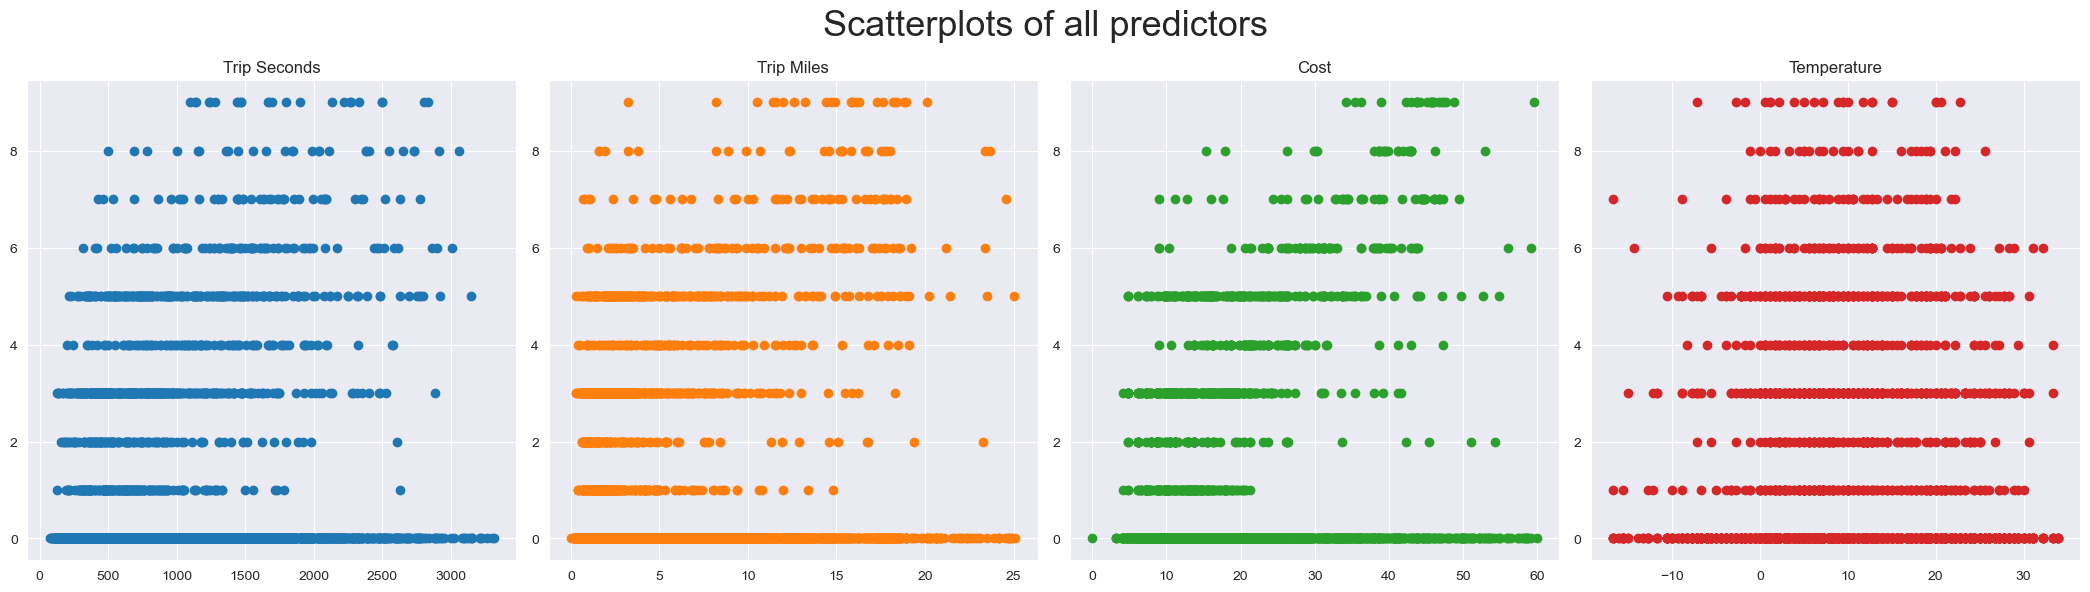

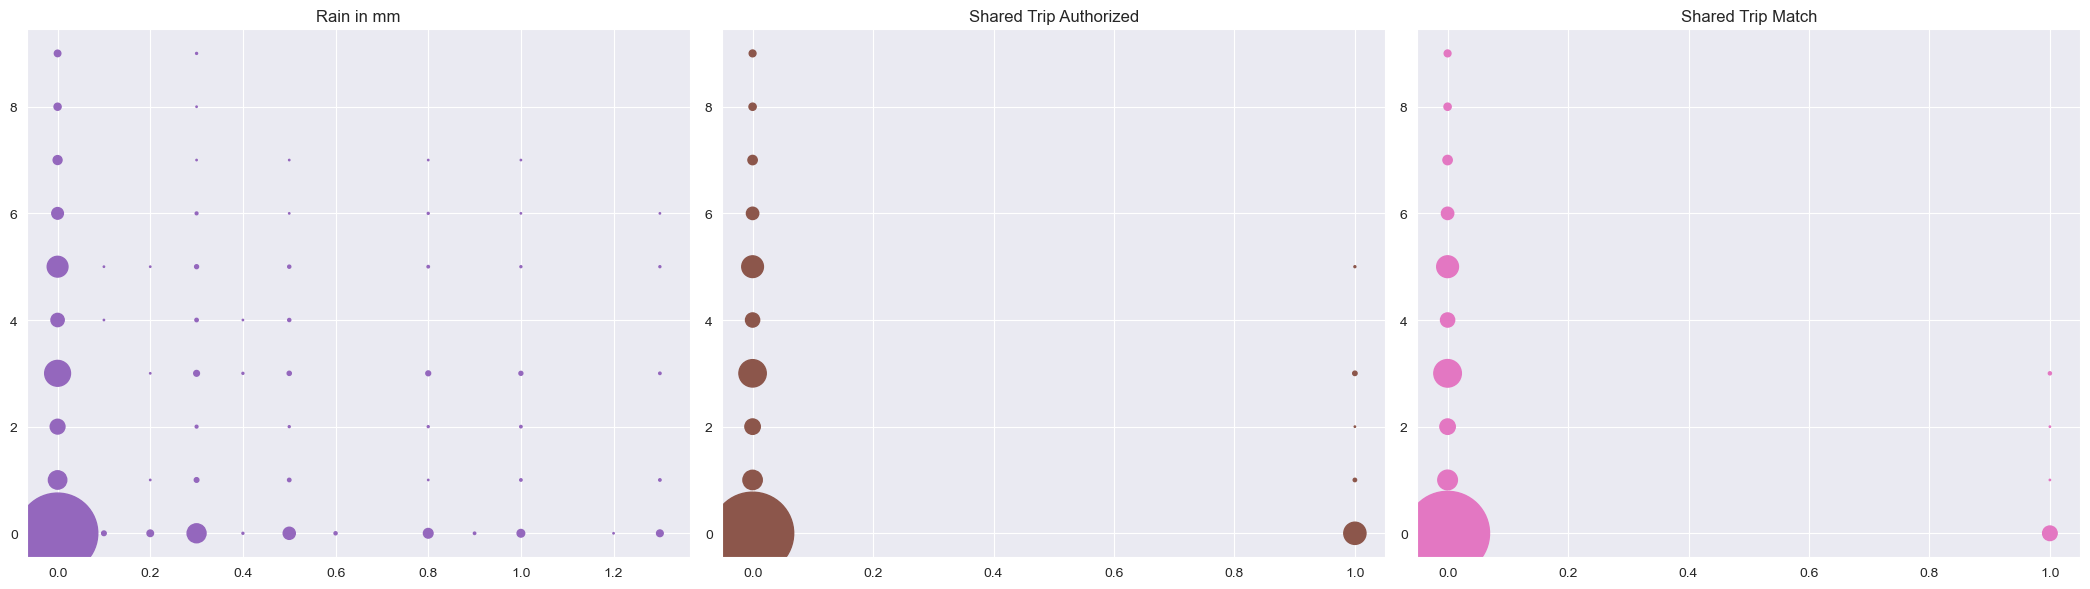

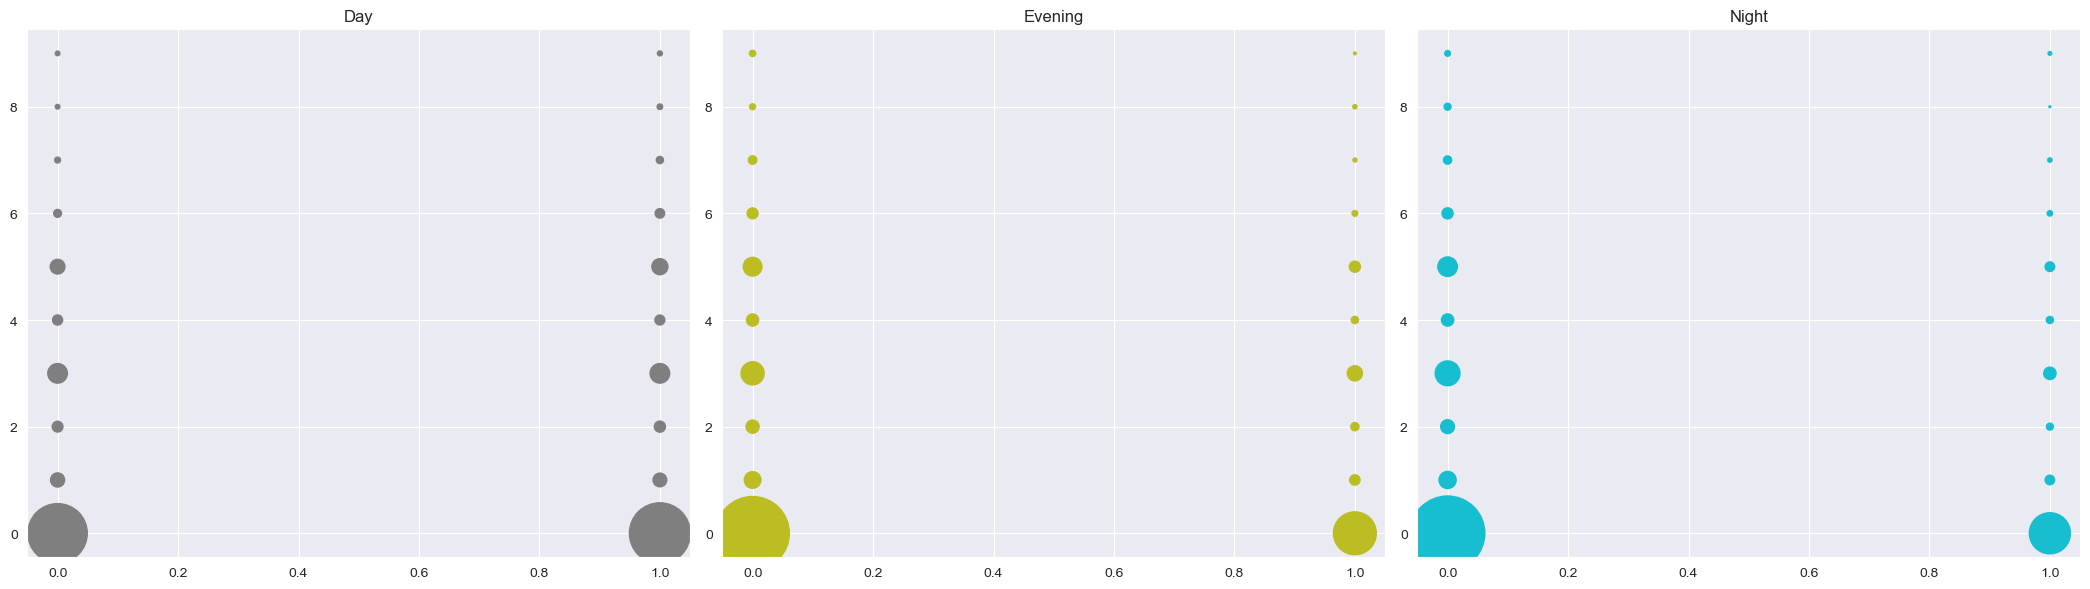

In [7]:
#Create Scatterplots for the first 4 predictors
fig_1, axes_1 = plt.subplots(nrows = 1, ncols = 4, figsize= (21,6))
fig_1.suptitle("Scatterplots of all predictors", fontsize=26)
for i, ax in enumerate(axes_1):
    ax.scatter(x = x_train_data.iloc[:5000, i], y = y_train_data[:5000], color = f'C{i}')
    ax.set_title(x_train_data.columns[i])
plt.tight_layout()
plt.show()

#Create Scatterplots for predictor 5-7
fig_2, axes_2 = plt.subplots(nrows = 1, ncols = 3, figsize= (21,6))
for i, ax in enumerate(axes_2):
    x_values = x_train_data.iloc[:5000, i + 4]
    y_values = y_train_data[:5000]
    
    # Kombiniere x und y Werte für das Zählen
    points_df = pd.DataFrame({'x': x_values, 'y': y_values})
    
    # Zähle die Häufigkeit jeder einzigartigen Kombination
    point_counts = points_df.groupby(['x', 'y']).size().reset_index(name='count')
    
    # Erstelle die Größen basierend auf der Anzahl (skaliert für bessere Sichtbarkeit)
    sizes = point_counts['count']
    
    ax.scatter(x = point_counts['x'], y = point_counts['y'], 
               s = sizes, color = f'C{i + 4}')
    ax.set_title(x_train_data.columns[i + 4])
plt.tight_layout()
plt.show()

#Create Scatterplots for predictor 8-10
fig_3, axes_3 = plt.subplots(nrows = 1, ncols = 3, figsize= (21,6))
for i, ax in enumerate(axes_3):
    x_values = x_train_data.iloc[:5000, i + 7]
    y_values = y_train_data[:5000]
    
    # Kombiniere x und y Werte für das Zählen
    points_df = pd.DataFrame({'x': x_values, 'y': y_values})
    
    # Zähle die Häufigkeit jeder einzigartigen Kombination
    point_counts = points_df.groupby(['x', 'y']).size().reset_index(name='count')
    
    # Erstelle die Größen basierend auf der Anzahl (skaliert für bessere Sichtbarkeit)
    sizes = point_counts['count']
    
    ax.scatter(x = point_counts['x'], y = point_counts['y'], 
               s = sizes, color = f'C{i + 7}')
    ax.set_title(x_train_data.columns[i + 7])
plt.tight_layout()
plt.show()

<h4 style="text-decoration: underline;">3.3 Data normalization</h4>
After plotting the data we get some interesting information. It looks like there are a lot of linear correlations for example between the costs and the tip. Moreover it is noticeable that the predictors are on diffrent scales so we need to normalize them to get meaningful result in our regression later on. For the normalization we make use of the python libary StandartScaler which uses the following formula:
\[
z = \frac{x - \mu}{\sigma}
\] 

In [8]:
#Select which Data to normalize (no Dummy Variables)
columns_to_normalize = ["Trip Seconds", "Trip Miles", "Cost", "Temperature", "Rain in mm"]


x_train_data_scaled = x_train_data.copy()
x_val_data_scaled = x_val_data.copy()
x_test_data_scaled = x_test_data.copy()


#Normalize data
scaler = StandardScaler()
x_train_data_scaled[columns_to_normalize] = scaler.fit_transform(x_train_data[columns_to_normalize])
#Hier nur noch transform verwenden, damit Mittelwert und Standardabweichung nicht neu berechnet werden
x_val_data_scaled[columns_to_normalize] = scaler.transform(x_val_data[columns_to_normalize])
x_test_data_scaled[columns_to_normalize] = scaler.transform(x_test_data[columns_to_normalize])

x_train_data_scaled.head()


,Trip Seconds,Trip Miles,Cost,Temperature,Rain in mm,Shared Trip Authorized,Shared Trip Match,Day,Evening,Night
21725870,-0.787051,-0.747516,-0.197862,-0.992238,2.315143,0,0,1,0,0
11506469,-0.464704,-0.374234,-0.464019,-0.731310,-0.297853,0,0,1,0,0
21483874,-0.469715,-0.726779,0.821229,-0.399219,6.495937,0,0,1,0,0
19976356,0.527387,2.342436,0.962910,-0.458521,-0.297853,0,0,0,0,1
13810485,-0.970771,-0.788992,-0.971035,-0.138290,-0.297853,0,0,0,1,0


<h4 style="text-decoration: underline;">3.4 Linear Regression</h4>

After finishing the data preperation and completing our descripive task we now want to start with our predictive models. First of all we want to create an simple linear regression because we have seen a few linear relationships between our predictors and the tip in the descriptive task above. An linear regression is a good first attemp to create good understandable machine learning models because it is easy to implement and to interpret. Espacially in approximatiely lineare realtionships (as we have seen in our scatter plots before) this model is really robust and gives us good predictions. But in complex problems (where the realationships are not linear) this easy approach could be too simple and is not usable in order to represent reality. So this step is used to see if our prediction problem could be solved well by an easy understandable model or if it needs more complex regression tasks to create appropriate predictions.
 
We define our linear regression model with the following input vector:
\begin{equation}
x^{(i)} = \left[ \begin{array}{c} 1 \\ \mathrm{Trip\ Seconds}^{(i)} \\ \mathrm{Trip\ Miles}^{(i)} \\ \mathrm{Shared\ Trip\ Authorized}^{(i)} \\ \mathrm{Shared\ Trip\ Matched}^{(i)} \\ \mathrm{Cost}^{(i)} \\ \mathrm{Temperature}^{(i)} \\ \mathrm{Rain\ in\ mm}^{(i)} \\ \mathrm{Night}^{(i)} \\ \mathrm{Day}^{(i)} \\
\mathrm{Evening}^{(i)} \end{array} \right] \end{equation}

In addition we create our linear hypothesis function $tip_\beta(x) = \beta^Tx$ is given by:

\begin{equation}
tip_\beta(x) = \beta_0 + \beta_1 * \mathrm{Trip\ Seconds}^{(i)} + \beta_2 * \mathrm{Trip\ Miles}^{(i)} + \beta_3 * \mathrm{Shared\ Trip\ Authorized}^{(i)} + \\ \beta_4 * \mathrm{Shared\ Trip\ Matched}^{(i)} + \beta_5 * \mathrm{Cost}^{(i)} + \beta_6 * \mathrm{Temperature}^{(i)} + \beta_7 * \mathrm{Rain\ In\ MM}^{(i)} + \\ \beta_8 * \mathrm{Night}^{(i)} + \beta_9 * \mathrm{Day}^{(i)} + \beta_{10} * \mathrm{Evening}^{(i)} 
\end{equation}

After defining our linear regression model, we now want to find the right values for our predictors $ \beta_0, \beta_1, \dots, \beta_9 $.


In [9]:
linear_model = LinearRegression()
linear_model.fit(x_train_data_scaled, y_train_data)
print("📋Values for our predictors:")
print(str(linear_model.coef_))

📋Values for our predictors:
[-8.96401267e-02 -1.37733937e-01  6.53221436e-01  2.23432598e-02
 -2.63979804e-03 -3.83248811e-01  3.25964622e-02 -2.91849376e+11
 -2.91849376e+11 -2.91849376e+11]


In [10]:
linear_model_prediction = linear_model.predict(x_val_data_scaled)
print("❌Mean absoulte Error:", round(mean_absolute_error(y_val_data, linear_model_prediction), 4), "\n🤖R²:", round(r2_score(y_val_data, linear_model_prediction), 4))

❌Mean absoulte Error: 1.3065 
🤖R²: 0.0799


As we can see, our model has a low R² value and a high error which indicates that the predictions from our linear model differ significantly from the actual values. We can visualize this by creating a scatter plot of the predicted tips versus the actual tip amounts and adding an ideal line that represents perfect predictions. This allows us to see how far off our model's predictions are from the ideal.

It becomes especially apparent that the model struggles with higher tip amounts (greater than $4) since it never predicts values above that threshold. This is probablly caused by the large number of zero values in our dataset, which lowers the slope of the regression line and makes the model systematically underestimate higher tips.

Another possible reason why our predtictions differ a lot from the actual tip is that the tips are rounded by the nearest 1.00(see buisness understanding above) which cannot be well represented by our linear model. Because the tip values are rounded to full euros we suggest that a classification approach will likely work better than regression. The large gaps between the data points make it difficult to fit a precise regression line. Instead it seems more effective to divide the data into 10 classes (from 0 to \$9) and predict one of these classes using classification algorithms

In conclusion it becomes visible that our simple regression model is not appropriate to depict the real world and we need to try out other (classifiction) approaches to create a better and more robust model.

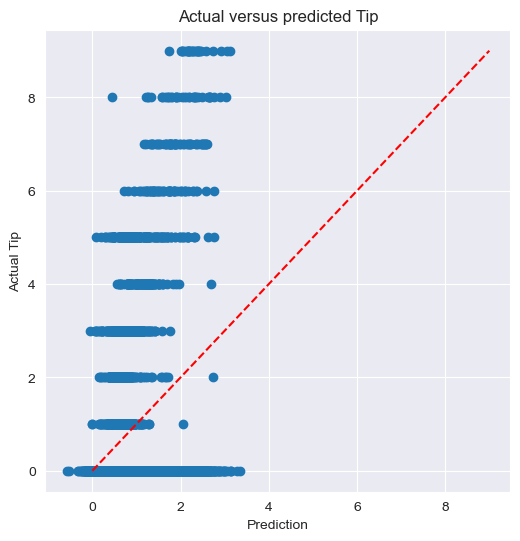

In [11]:
plt.figure(figsize=(6, 6))
#Plot ideal line
plt.plot([y_val_data.min(), y_val_data.max()], [y_val_data.min(), y_val_data.max()], 'r--')
#Scatter plot prediction versus actual tip
plt.scatter(linear_model_prediction[:5000], y_val_data[:5000])
plt.xlabel('Prediction')
plt.ylabel('Actual Tip')
plt.title('Actual versus predicted Tip')
plt.show()

<h4 style="text-decoration: underline;">3.5 Decision Tree</h4>
As mentioned before our linear regression approach did not perform very well so we would like to try a completely different method that will hopefully yield better results.  we plan to use decision trees as a classification approach.

We believe that classification could create a more robust model because our data is rounded to the nearest \$1.00, resulting in 10 different classes (from \$0 to \$9). Instead of predicting continuous values, this method will predict which of these classes a data point belongs to. As a result it avoids producing values between these discrete classes which should lead to more precise and accurate predictions compared to our previous regression approach.

At first we want to define some methods which help us to visualize the performance of our model.

In [13]:
#Method to get some basic informations about our tree's performance
def tree_performance_test(predictions, y_data, isBinary=False):
    print(f"Accuracy: {accuracy_score(y_data, predictions):.4f}")
    if isBinary:
        print(f"Recall (Percentage of recognized 1s): {recall_score(y_data, predictions):.4f}")
        print(f"Precision (percentage of '1' predictions that were correct) {precision_score(y_data, predictions):.4f}")
        print(f"F1-Score: {f1_score(y_data, predictions):.4f}")
        print("---")
    else:
        print(f"Recall (Average proportion of true predictions to all predictions per class): {recall_score(y_data, predictions, average='macro'):.4f}")
        print(f"Precision (Average proportion of values per class that were predicted): {precision_score(y_data, predictions, average='macro'):.4f}")
        print(f"F1-Score: {f1_score(y_data, predictions, average='macro'):.4f}")
    non_zero_predictions = (predictions != 0).sum()
    zero_predictions = (predictions == 0).sum()
    print(f"Number of non-zero predictions: {non_zero_predictions}")
    print(f"Number of 0 predictions: {zero_predictions}")
    print()

In [14]:
#Method to plot the correct predicted tips vs the whole amount of tips
def show_correctness(predictions, y_val_data, max=None):
    plt.figure(figsize=(5, 5))
    right_counts = []
    sum = []
    for i in range(int(y_val_data.max()) + 1):
        right_predictions = ((predictions == i) & (y_val_data == i)).sum()
        sum_predictions = (y_val_data == i).sum()
        right_counts.append(right_predictions)
        sum.append(sum_predictions)
    tips = range(int(y_val_data.max()) + 1) 
    plt.bar(tips, sum, label = "Total Tips")
    plt.bar(tips, right_counts, label = "Correct predicted")
    plt.ylabel("Total Tips in million")
    plt.xlabel("Tip amounts")
    plt.legend()
    if max is not None:
        plt.ylim(0, max)
    plt.show()

In [15]:
def accuracy_zero_non_zero(predictions, val_data):
    # Filtere nur Fälle wo tatsächlich ein Tip gegeben wurde
    non_zero_mask = val_data != 0
    non_zero_predictions = predictions[non_zero_mask]
    non_zero_actual = val_data[non_zero_mask]

    # Berechne Accuracy nur für diese Fälle
    accuracy_non_zero = (non_zero_predictions == non_zero_actual).sum() / len(non_zero_actual)
    print(f"✅ Accuracy for cases with tip: {accuracy_non_zero:.4f}")



    # Filtere nur Fälle wo tatsächlich ein Tip gegeben wurde
    zero_mask = val_data == 0
    zero_predictions = predictions[zero_mask]
    zero_actual = val_data[zero_mask]

    # Berechne Accuracy nur für diese Fälle
    accuracy_zero = (zero_predictions == zero_actual).sum() / len(zero_actual)
    print(f"✅ Accuracy for cases without tip: {accuracy_zero:.4f}")

After defining the methods we now start with our classification model. As an first approach we want to train a simple Decision Tree using our training data and then analyze it's performance with the validation dataset. 

In [28]:
#Count the amount of zeros in our test dataset 
zero_tip_count = (y_test_data == 0).sum()
total_count = len(y_test_data)
zero_tip_percentage = (zero_tip_count / total_count) * 100
print(f"📊 {zero_tip_count} Rows have 'Tip' = 0 ({zero_tip_percentage:.1f}%)")


📊 2555921 Rows have 'Tip' = 0 (75.5%)


In [32]:
tree_model = DecisionTreeClassifier(max_depth=5, random_state = 42)
tree_model.fit(x_train_data, y_train_data)
predictions = tree_model.predict(x_val_data)
tree_performance_test(predictions, y_val_data)

Accuracy: 0.7552
Recall (Durchschnittlicher Anteil wahrer Vorhersagen an allen Vorhersagen pro Klasse): 0.1000
Precision (Durchschnittlicher Anteil an Werten pro Klasse, die vorhergesagt wurden): 0.0755
F1-Score: 0.0861
Anzahl der nicht-0-Vorhersagen: 0
Anzahl der 0-Vorhersagen: 3384947



In [35]:
tree_model = DecisionTreeClassifier(max_depth=60, random_state = 42)
tree_model.fit(x_train_data, y_train_data)
predictions = tree_model.predict(x_val_data)

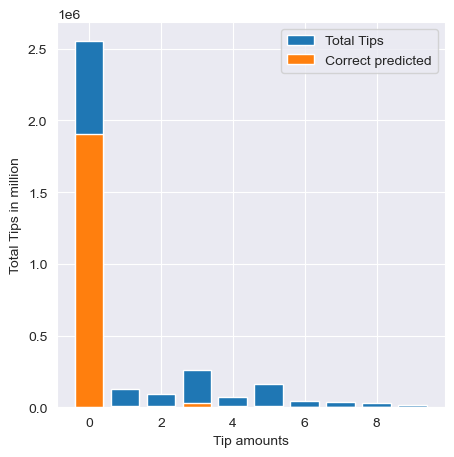

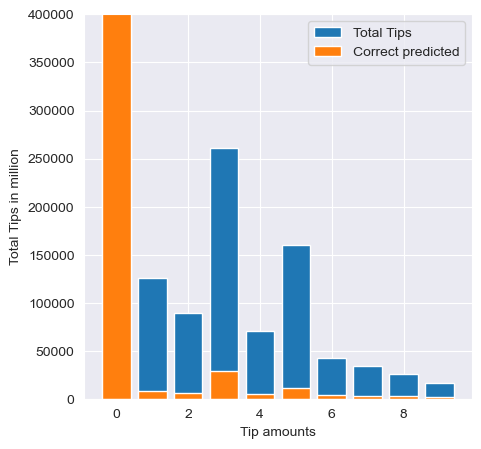

Accuracy: 0.5848
Recall (Durchschnittlicher Anteil wahrer Vorhersagen an allen Vorhersagen pro Klasse): 0.1626
Precision (Durchschnittlicher Anteil an Werten pro Klasse, die vorhergesagt wurden): 0.1575
F1-Score: 0.1599
Anzahl der nicht-0-Vorhersagen: 900355
Anzahl der 0-Vorhersagen: 2484592



In [36]:
show_correctness(predictions, y_val_data)
show_correctness(predictions, y_val_data, max=400000)
tree_performance_test(predictions, y_val_data)

In [49]:
for i in range(10):
    x = (predictions == i).sum()
    y = ((predictions == i) & (y_val_data == i)).sum()
    print("Number of predicted", i ,":",  x)
    print("Right Predictions: ", y)
    print("Percentage of correct predictions: ", y / x * 100 if x > 0 else 0)

# Berechne den Mean Absolute Error
mae = mean_absolute_error(y_val_data, predictions)
print(f"❌ Mean Absolute Error: {mae:.4f}")

Number of predicted 0 : 2484592
Right Predictions:  1903999
Percentage of correct predictions:  76.63225994448987
Number of predicted 1 : 136934
Right Predictions:  8281
Percentage of correct predictions:  6.047438912176669
Number of predicted 2 : 95872
Right Predictions:  6097
Percentage of correct predictions:  6.359521028037383
Number of predicted 3 : 279070
Right Predictions:  29776
Percentage of correct predictions:  10.669724441896298
Number of predicted 4 : 79350
Right Predictions:  5989
Percentage of correct predictions:  7.547574039067423
Number of predicted 5 : 177148
Right Predictions:  11857
Percentage of correct predictions:  6.693273421094226
Number of predicted 6 : 47184
Right Predictions:  3997
Percentage of correct predictions:  8.471091895557818
Number of predicted 7 : 37417
Right Predictions:  3934
Percentage of correct predictions:  10.513937515033273
Number of predicted 8 : 28646
Right Predictions:  3303
Percentage of correct predictions:  11.53040564127627
Number 

As we can see, due to the very high proportion of $0 tips (around 75%), a simple decision tree will almost always predict 0 since this prediction has by far the highest chance of being correct. Especially when using a shallow tree (i.e. low tree depth) the model fails to identify any meaningful patterns in the data that would justify predicting values other than 0.

Even when we increase the tree depth ,which increases the risk of overfitting to the training data, this problem cannot be fully resolved. Although the tree starts to predict some non-zero values, it often predicts the wrong non-zero class, resulting in a low highest accuracy of around 13%. Additionally, the overall accuracy drops to about 58% which is likely a consequence of the overfitting caused by the deeper tree.

In consequence, we want to create a second hopefully more precise model which contains two diffrent classification steps. First we want to create a model which either predicts if the tip is zero or not. This helps to reduce the overwhelming share of zeros in the dataset for our second prediction model. After filtering out the zero tips, we can then train a second classification model on the remaining data. This second model should be able to make more accurate predictions of the actual tip class because it is no longer dominated by zeros.
.

In [39]:
#For the first model we need to transform our data into binary datatype
y_train1_binary = (y_train1_data != 0).astype(int)  # 1 if tip != 0 else 0
y_val_binary = (y_val_data != 0).astype(int)

Accuracy: 0.6093
Recall (Anteil 1er, die erkannt wurden): 0.5194
Precision (Anteil 1er-Vorhersagen, die Richtig waren): 0.3177
F1-Score: 0.3942
---
Anzahl der nicht-0-Vorhersagen: 1354796
Anzahl der 0-Vorhersagen: 2030151



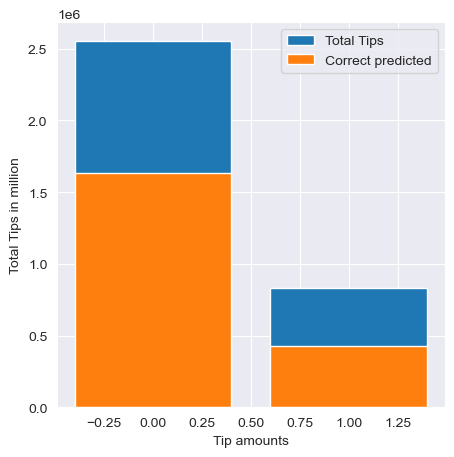

In [40]:
binary_model = DecisionTreeClassifier(max_depth=15, random_state = 42, class_weight={0: 1, 1: 2.8})
binary_model.fit(x_train1_data, y_train1_binary)
binary_predictions = binary_model.predict(x_val_data)

tree_performance_test(binary_predictions, y_val_binary, isBinary=True)
show_correctness(binary_predictions, y_val_binary)

 As we can see, the dominant class 0 has only become slightly smaller(from 75% to 67%). So the first model did not seem to work as well as we had hoped. Nevertheless we still want to train our second model which predicts the tip class for the non-zero data.

In [20]:
# Use model 1 for predicting x_train2_data, to only train the regression model on rides where a tip was predicted
predictions_train2 = binary_model.predict(x_train2_data)

# Filter both x and y data based on the predictions
mask = predictions_train2 != 0
x_train2_data = x_train2_data[mask]
y_train2_data = y_train2_data[mask]

print(f"📊 Filtered Data: {len(x_train2_data)} Samples (before: {len(predictions_train2)})")

📊 Gefilterte Daten: 3158667 Samples (vorher: 7898209)


In [21]:
#Train second model
second_model = DecisionTreeClassifier(max_depth=13, random_state = 42)
second_model.fit(x_train2_data, y_train2_data)

DecisionTreeClassifier(max_depth=13, random_state=42)

In [41]:
#Method to first make the whole predicition process (first prediction model 1 and then prediction model 2)
def DualTree(data):
    # Binary predictions: predict whether there is a tip or not
    binary_predictions = binary_model.predict(data)

    # For rows where a tip is predicted (binary_prediction == 1),
    # get the predicted tip amount/class from the second model
    tip_amount_predictions = second_model.predict(data[binary_predictions == 1])

    # Combine both: assign 0 where no tip is predicted,
    # and assign predicted tip values where a tip is predicted
    final_predictions = np.zeros(len(binary_predictions))
    final_predictions[binary_predictions == 1] = tip_amount_predictions

    return final_predictions

In [42]:
final_predictions = DualTree(x_val_data)

correct_predictions = (final_predictions == y_val_data).sum()
print(f"✅ Korrekte Vorhersagen: {correct_predictions} von {len(y_val_data)} ({correct_predictions / len(y_val_data) * 100:.2f}%)")


✅ Korrekte Vorhersagen: 2554630 von 3384947 (75.47%)


In [53]:
#Print accuracy for each group
for i in range(10):
    x = (final_predictions == i).sum()
    y = ((final_predictions == i) & (y_val_data == i)).sum()
    print("Number of predicted", i ,":",  x)
    print("Right Predictions: ", y)
    print("Percentage of correct predictions: ", y / x * 100 if x > 0 else 0)

Number of predicted 0 : 3381536
Right Predictions:  2554200
Percentage of correct predictions:  75.53372195357376
Number of predicted 1 : 153
Right Predictions:  9
Percentage of correct predictions:  5.88235294117647
Number of predicted 2 : 165
Right Predictions:  9
Percentage of correct predictions:  5.454545454545454
Number of predicted 3 : 1038
Right Predictions:  160
Percentage of correct predictions:  15.414258188824661
Number of predicted 4 : 491
Right Predictions:  73
Percentage of correct predictions:  14.867617107942973
Number of predicted 5 : 643
Right Predictions:  65
Percentage of correct predictions:  10.10886469673406
Number of predicted 6 : 373
Right Predictions:  43
Percentage of correct predictions:  11.528150134048257
Number of predicted 7 : 287
Right Predictions:  35
Percentage of correct predictions:  12.195121951219512
Number of predicted 8 : 156
Right Predictions:  21
Percentage of correct predictions:  13.461538461538462
Number of predicted 9 : 105
Right Predicti

In [44]:
# Calculate Mean Absolute Error
mae = mean_absolute_error(y_val_data, final_predictions)
print(f"❌ Mean Absolute Error: {mae:.4f}")

❌ Mean Absolute Error: 0.8991


In [48]:
# Filtere nur Fälle wo tatsächlich ein Tip gegeben wurde
non_zero_mask = y_val_data != 0
non_zero_predictions = final_predictions[non_zero_mask]
non_zero_actual = y_val_data[non_zero_mask]

# Berechne Accuracy nur für diese Fälle
accuracy_non_zero = ((non_zero_predictions == non_zero_actual).sum() / len(non_zero_actual))*100
print(f"✅ Accuracy für Fälle mit Tip: {accuracy_non_zero:.4f}")

✅ Accuracy für Fälle mit Tip: 0.0519


In [57]:
#Calculate overall accuracy
right_predictions = (final_predictions == y_val_data).sum()
overall_accuracy = right_predictions / len(y_val_data) *100
print(f"✅ Overall Accuracy: {overall_accuracy:.4f}%")

✅ Overall Accuracy: 75.4703%


<h4 style="text-decoration: underline;">4. Implication/Reflection</h4>

<h4 style="text-decoration: underline;">4.1 Linear Regression</h4>
Let's take a look at the final perfomance of our predictive models using the test dataset.

In [ ]:
# Linear Regression Model
linear_model_prediction = linear_model.predict(x_test_data_scaled)
print("❌Mean absoulte Error:", round(mean_absolute_error(y_test_data, linear_model_prediction), 4), "\n🤖R²:", round(r2_score(y_test_data, linear_model_prediction), 4))

Assuming that our data was collected correctly, the results of our linear regression show that the model can explain only about 8% of the total variance in the target values (R² = 0.08). Additionally, the mean absolute error (MAE) is relatively high, which means that the predictions deviate significantly from the actual values on average. Such a low explanatory rate suggests that essential influencing factors are missing or that relationships are not correctly depicted. This means for all decision makers that the model does not make reliable predictions for any strategic or operational decisions and should therefore not be used. 

In order to improve the model's performance, it should be evaluated whether there are additional relevant features that could be included. This might involve incorporating other variables from the existing dataset or creating new features (e.g. polynomial features). Additionally, it would be reasonable to test non-linear modeling approaches as they might capture the real-world relationships more accurately than the current linear model (e.g. Radial Basis Function).

Moreover, it could make sense to include further analyses. For example, we could review the existing features and remove those that do not significantly contribute to the prediction. To do this we could use Lasso regression which is particularly useful after implementing the improvements mentioned above if our model ends up containing a large number of features (feature selection).


<h4 style="text-decoration: underline;">4.2 Decision Tree</h4>

In [ ]:
# Decision Tree Model with max_depth=60
tree_model_prediction = tree_model.predict(x_test_data)
print("❌Mean absoulte Error:", round(mean_absolute_error(y_test_data, tree_model_prediction), 4), "\n Accuracy:", round(accuracy_score(y_test_data, tree_model_prediction), 4))
accuracy_zero_non_zero(tree_model_prediction, y_test_data)

In [ ]:
dual_tree_prediction = DualTree(x_test_data)
print("❌Mean absoulte Error:", round(mean_absolute_error(y_test_data, dual_tree_prediction), 4), "\n Accuracy:", round(accuracy_score(y_test_data, dual_tree_prediction), 4))
accuracy_zero_non_zero(dual_tree_prediction, y_test_data)